# Bayesian Analysis of MLB Payrolls

Can you buy wins in baseball? Baseball is well known for having gross discrepancies in team payrolls, Alex Rodriguez of the New York Yankees made more money this year than the entire Houston Astros roster. Intuitively more money should buy better players and result in more wins on average. Let's test our intuition by comparing payrolls with the final regular season standings.

[Baseball Almanac](http://www.baseball-almanac.com) has payroll data from 1985 to 2012.
Unfortunately it isn't readily downloadable, so it has to be scraped.
With Beautiful Soup this task isn't too difficult and I stuff the data into a handy pandas data frame.

In [11]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

crm = str.maketrans('', '', '$,\n')

data = []
for year in range(1985, 2013):
    for league in ('a', 'n'):
        r = requests.get('http://www.baseball-almanac.com/yearly/yr' +
                         str(year) + league + '.shtml')
        assert(r.ok)
        soup = BeautifulSoup(r.text)

        header = soup.find(text='Team Standings').find_parent('tr')
        for r in header.find_next_siblings():
            entries = r.find_all('td')
            if len(entries) > 1 and entries[1].text.isdigit():
                d = {}
                d['year'] = year
                d['team'] = entries[0].text.replace('\n', '')
                d['wins'] = int(entries[1].text)
                d['payroll'] = int(entries[-1].text.translate(crm))
                data.append(d)

df = pd.DataFrame(data)

In [12]:
len(df)

795

We have 795 data points and let's take a quick glance at the data.

In [13]:
df[(df.team == 'Oakland Athletics') & (df.year.isin(range(2008,2013)))]

,payroll,team,wins,year
657,47967126,Oakland Athletics,75,2008
688,62310000,Oakland Athletics,75,2009
716,51654900,Oakland Athletics,81,2010
747,66536500,Oakland Athletics,74,2011
775,55372500,Oakland Athletics,94,2012


The last five years of data for Oakland looks good so let's continue.

# Constructing a Model

I'm going to assume the probability of winning a game is solely a function of a team's payroll, specifically the fraction that team spent compared to the entire league.
As implied by the title I'm going to take a Bayesian approach and use a generalized linear model.
The likelihood for number of wins will be a binomial with $n=162$ and $p = 1/(1 + e^{-(\theta_1 x + \theta_2)})$, where $x$ is the team's fractional payroll.
The priors on the parameters will be Normal, $\theta_1 \sim N(0, \sigma^2_1)$ and $\theta_2 \sim N(0, \sigma^2_2)$.
The hyperparameters $\sigma^2_1$ and $\sigma^2_2$ are fixed.
With the model specified we just need to turn the Bayesian crank to get the posterior distributions for $\theta$ and determine how payrolls influence the game.

First we need to transform the payroll data into the percentage of the league's payroll in total.

In [14]:
grouped = df.groupby('year')
df['payroll_percent'] = grouped['payroll'].transform(lambda x: x / x.sum())

Let's define our likelihood and prior functions.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom, uniform
%matplotlib inline

def sigmoid(theta_1, theta_2, x):
    return 1/(1 + np.exp(-(theta_1*x + theta_2)))

def logprior(theta_1, theta_2):
    return norm.logpdf(theta_1, 0, 10) + norm.logpdf(theta_2, 0, 1)

def loglikelihood(theta_1, theta_2):
    return binom.logpmf(df.wins, 162, sigmoid(theta_1, theta_2, df.payroll_percent)).sum()

def logposterior(theta_1, theta_2):
    return loglikelihood(theta_1, theta_2) + logprior(theta_1, theta_2)

Now we can compute the posterior.

In [16]:
XSIZE = 500
YSIZE = 250
XLIM = 30
YLIM = 2
X, Y = np.meshgrid(np.linspace(-XLIM, XLIM, XSIZE),
                   np.linspace(-YLIM, YLIM, YSIZE))
pri = logprior(X, Y)
post = np.empty((YSIZE, XSIZE))
for i in range(YSIZE):
    for j in range(XSIZE):
        post[i,j] = loglikelihood(X[i,j], Y[i,j]) + pri[i,j]
post_max = post.max()
post = post - post_max  # normalize by an arbitrary factor

Note that the posterior distribution isn't normalized properly, it is just a scaled version of the true posterior. Let's plot them.

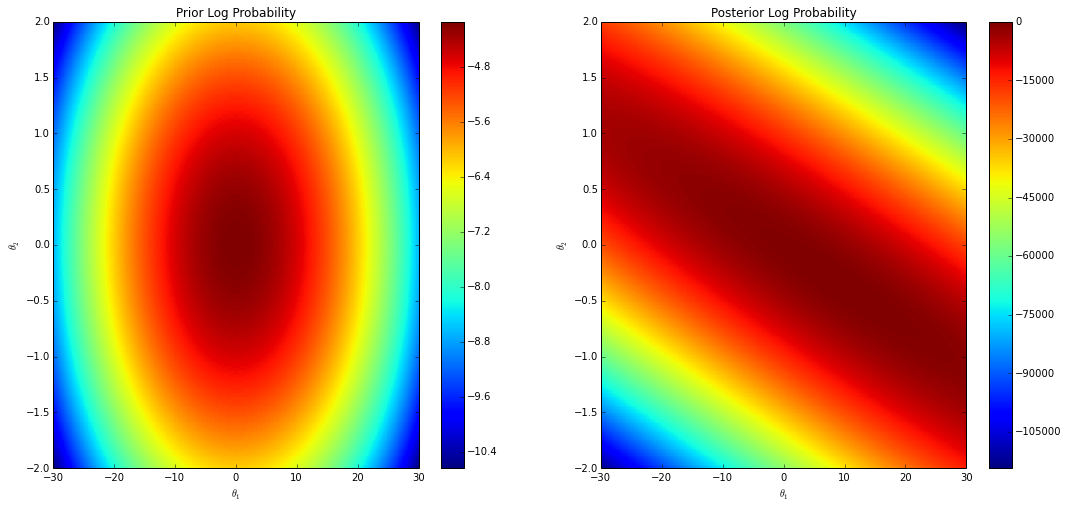

In [17]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
p = ax1.pcolor(X, Y, pri)
ax1.set_title('Prior Log Probability')
ax1.set_xlabel(r'$\theta_1$')
ax1.set_ylabel(r'$\theta_2$')
fig1.colorbar(p, ax=ax1)
p = ax2.pcolor(X, Y, post)
ax2.set_title('Posterior Log Probability')
ax2.set_xlabel(r'$\theta_1$')
ax2.set_ylabel(r'$\theta_2$')
fig1.colorbar(p, ax=ax2);

This visualization isn't the greatest but looking carefully at the posterior distribution it appears to be Gaussian centered around the maximum at roughly (9, -0.35).

In [18]:
amax = np.unravel_index(np.argmax(post), post.shape)
X[amax], Y[amax]

(8.9579158316633283, -0.34538152610441775)

Let's take a closer look at $\theta_1$, since that encodes the linear relationship, by computing the marginal posterior.

In [19]:
from functools import partial
from scipy.integrate import quad

def posterior(theta_1, theta_2):
    return np.exp(logposterior(theta_1, theta_2) - post_max)

postx = np.linspace(0, 20, 200)
post_theta_1 = np.empty(postx.size)
post_theta_err = np.empty(postx.size)
m = -2 / 60
y = Y[amax] - X[amax]*m
for i, x in enumerate(postx):
    llh = partial(posterior, x)
    post_theta_1[i], post_theta_err[i] = np.log(quad(llh, m*x + y - 0.5, m*x + y + 0.5))

Let's fit a normal distribution to this marginal posterior

In [20]:
from scipy.optimize import brentq

mu_hat = postx[post_theta_1.argmax()]
logdiff = post_theta_1.max() - post_theta_1[0]
logpdfpartial = partial(norm.logpdf, -mu_hat, 0)
sigma2_hat = brentq(lambda x: norm.logpdf(0, 0, x) - logpdfpartial(x) - logdiff, 0.001, 2)
# attempt to normalize, use range with best numerical accuracy
subset = list(range(65, 115))
diff = np.mean(post_theta_1[subset] - norm.logpdf(postx, mu_hat, sigma2_hat)[subset])

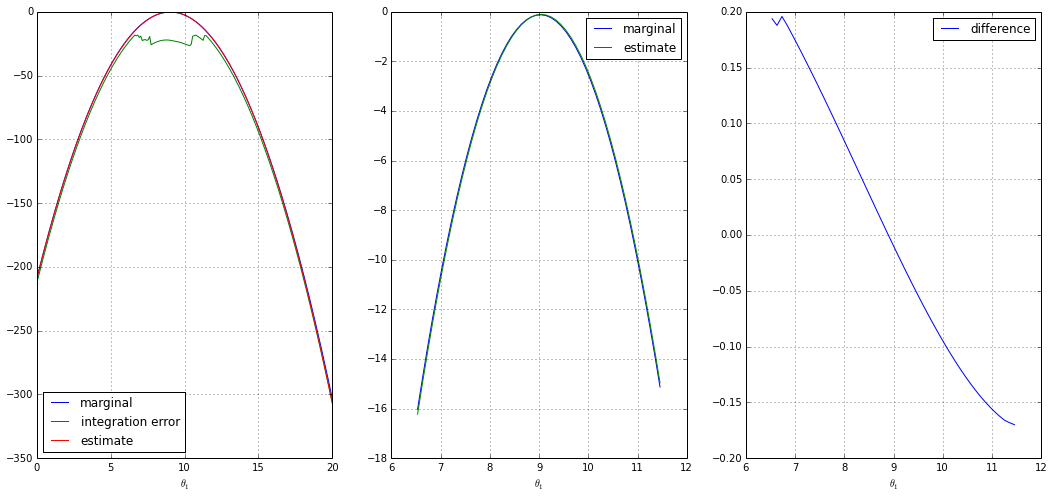

In [21]:
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,8))
ax1.plot(postx, post_theta_1 - diff, label='marginal')
ax1.plot(postx, post_theta_err, label='integration error')
ax1.plot(postx, norm.logpdf(postx, mu_hat, sigma2_hat), label='estimate')
ax1.legend(loc=3); ax1.grid(); ax1.set_xlabel(r'$\theta_1$')
ax2.plot(postx[subset], post_theta_1[subset] - diff, label='marginal')
ax2.plot(postx[subset], norm.logpdf(postx[subset], mu_hat, sigma2_hat), label='estimate')
ax2.legend(); ax2.grid(); ax2.set_xlabel(r'$\theta_1$')
ax3.plot(postx[subset], (post_theta_1[subset] - diff) - norm.logpdf(postx[subset], mu_hat, sigma2_hat), label='difference')
ax3.legend(); ax3.grid(); ax3.set_xlabel(r'$\theta_1$');

Looks pretty good to me! Now that we have an analytic distribution we can do all sorts of things, like plot confidence intervals.

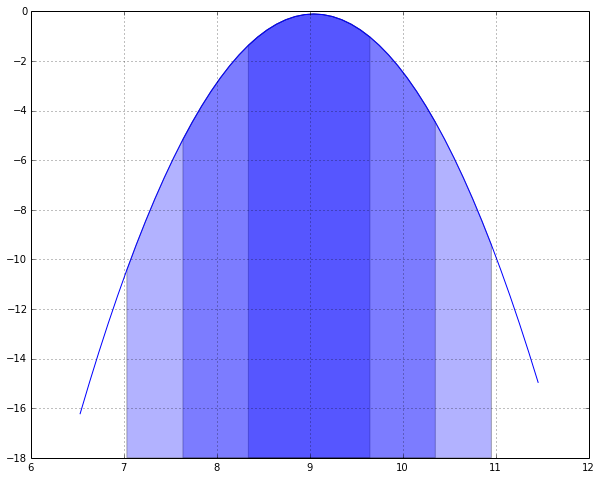

In [22]:
def std_range(n):
    return range(np.nonzero(postx < mu_hat - n*np.sqrt(sigma2_hat))[0][-1], np.nonzero(postx > mu_hat + n*np.sqrt(sigma2_hat))[0][0])

fig3, ax = plt.subplots()
ax.plot(postx[subset], norm.logpdf(postx[subset], mu_hat, sigma2_hat))
std1 = list(std_range(1))
std2 = list(std_range(2))
std3 = list(std_range(3))
ax.fill_between(postx[std1], norm.logpdf(postx[std1], mu_hat, sigma2_hat), ax.get_ylim()[0], alpha=0.3)
ax.fill_between(postx[std2], norm.logpdf(postx[std2], mu_hat, sigma2_hat), ax.get_ylim()[0], alpha=0.3)
ax.fill_between(postx[std3], norm.logpdf(postx[std3], mu_hat, sigma2_hat), ax.get_ylim()[0], alpha=0.3)
ax.grid();

I've plotted the distribution again and shaded in the first, second and third standard deviation bands. Let's take a somewhat conservative value for $\theta_1$ by taking the minimum value still falling within two standard deviations, so $\widehat\theta_1 \approx 7.64$. Given this let's find the MAP estimate of $\widehat\theta_2$ and use that to demonstrate the effect of money on MLB.

In [23]:
from scipy.optimize import minimize_scalar

theta_1_hat = postx[std2[0]]
llh = partial(logposterior, theta_1_hat)
theta_2_hat = minimize_scalar(lambda x: -llh(x)).x

This gives a $\widehat\theta_2 \approx -0.3$.



[Deadspin](http://deadspin.com/2013-payrolls-and-salaries-for-every-mlb-team-462765594) has listed the 2013 opening day payrolls. Let's compare how this model predicts how well the New York Yankees, with a payroll of 229 million should have done to the Houston Astros meager 24 million payroll.

In [47]:
payrolls_2013 = np.array([228995945,216302909,159578214,158967286,149046844,142180333,142165250,127197575,124065277,118244039,116702085,112431770,110565728,104150726,91793333,91003366,90158500,89288193,88877033,84295952,82517300,80491725,75562500,75449071,71689900,68577000,66289524,57030272,39621900,24328538])
yankees = payrolls_2013.max() / payrolls_2013.sum()
astros = payrolls_2013.min() / payrolls_2013.sum()
p_yankees = sigmoid(theta_1_hat, theta_2_hat, yankees)
p_astros = sigmoid(theta_1_hat, theta_2_hat, astros)
payroll_space = np.linspace(0, payrolls_2013.max(), 200)

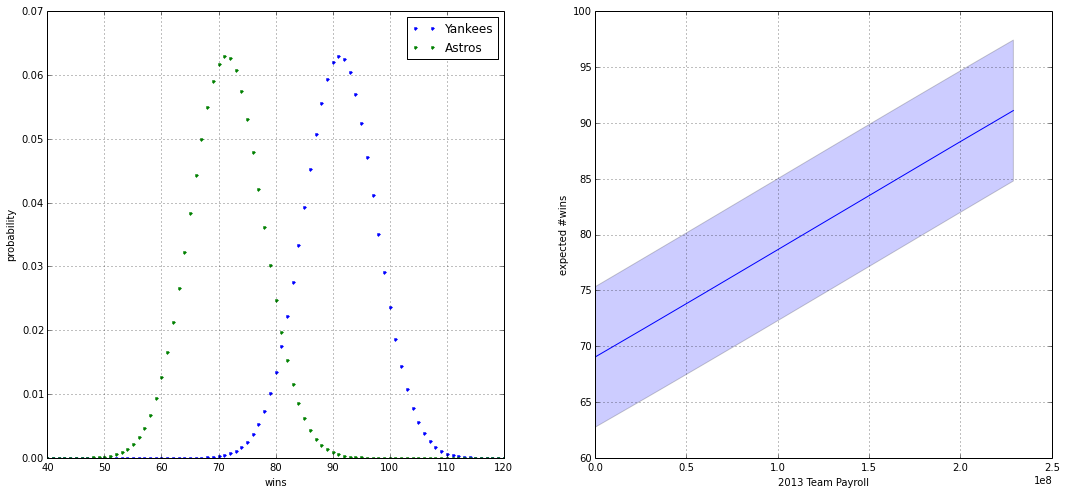

In [49]:
fig4, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
ax1.plot(range(40,121), binom.pmf(range(40,121), 162, p_yankees), '.', label='Yankees')
ax1.plot(range(40,121), binom.pmf(range(40,121), 162, p_astros), '.', label='Astros');
ax1.legend(); ax1.grid()
ax1.set_xlabel('wins'); ax1.set_ylabel('probability');
p = sigmoid(theta_1_hat, theta_2_hat, payroll_space / payrolls_2013.sum())
ax2.plot(payroll_space, 162 * p)
ax2.fill_between(payroll_space, np.sqrt(162 * p * (1 - p)) + 162 * p, -np.sqrt(162 * p * (1 - p)) + 162 * p, alpha=0.2)
ax2.set_ylabel('expected #wins'), ax2.set_xlabel('2013 Team Payroll')
ax2.grid()

We have a couple graphs that display the predicted distributions for the number of games the Astros and Yankees would win. On the right is how the expected number of wins varies with a team's payroll. It's interesting that it appears so linear. I might have expected to see diminishing returns due to the effect of the sigmoid function, but clearly that isn't happening.

The Yankees won 85 games this year while the Astros won a meager 51. Let's see how well this model handles these samples.

In [26]:
print('Astros probability of winning 51 or fewer games = %f%%' % (100 * binom.cdf(51, 162, p_astros)))
print('Yankees probability of winning 85 or fewer games = %f%%' % (100 * binom.cdf(85, 162, p_yankees)))

Astros probability of winning 51 or fewer games = 0.072077%
Yankees probability of winning 85 or fewer games = 18.672100%


For the Astros, this model fails to accurately forecast their woeful season. This model predicts that they would win 51 games or fewer in less than 1 in a 1000 seasons given their payroll in relation to the league. Not very predictive! This model does much better with the Yankees. Although the Yankees also underperformed according to this model, at least their showing was feasible.

Obviously much more analysis can be done, but I have to stop somewhere. Perhaps I'll revisit this topic at later date. I think it might be fun to analyze how good different GMs are with spending money (i.e. how many more wins can they extract per dollar than your average GM).

*This blog post was written entirely in the [IPython](http://ipython.org) Notebook.
The full notebook can be downloaded
[here](http://nbviewer.ipython.org/github/jwkvam/jwkvam.github.io/blob/master/notebooks/baseball_payrolls.ipynb),
or viewed statically
[here](http://nbviewer.ipython.org/url/jwkvam.github.io/notebooks/baseball_payrolls.ipynb).
You can find me on [GitHub](https://github.com/jwkvam), [LinkedIn](https://linkedin.com/in/jwkvam) and [Twitter](https://twitter.com/jwkvam).*